In [1]:
# !brew install cmake

In [2]:
# !pip install dlib

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import dlib

In [4]:
my_image_path = '../data/camera_sticker/'

## Step 1. 스티커 구하기 or 만들기

1. 셀카사진 업로드
2. flaticon 사이트에서 이미지들을 다운로드 받아 사용했습니다.

https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1

## Step 2. 얼굴 검출 & 랜드마크 검출 하기

오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

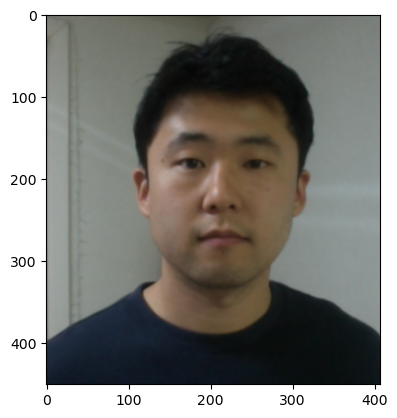

In [5]:
#사진 준비
faceimg = my_image_path +'/me2.png'
face = cv.imread(faceimg,-1).copy()
plt.imshow(cv.cvtColor(face, cv.COLOR_BGR2RGB))
plt.show()

In [6]:
#얼굴 검출 face detection using HOG(Histogram of Oriented Gradients)
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환
face_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(face_rgb,2) #upsampling
print(dlib_rects) 

rectangles[[(122, 123) (315, 315)]]


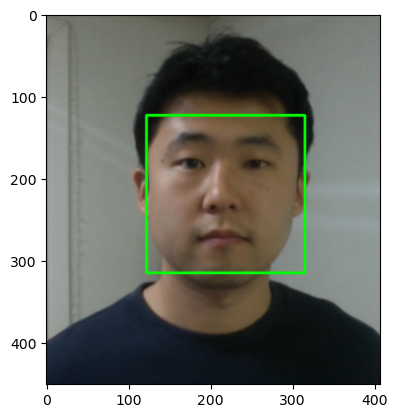

In [7]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽
    
    cv.rectangle(face, (l,t),(r,b),(0,255,0),2,lineType=cv.LINE_AA)

face_show_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
plt.imshow(face_show_rgb)
plt.show()

## Step 3. 스티커 적용 위치 확인하기

In [8]:
# 잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.
# Dlib의 제공되는 모델을 사용해보겠습니다. 먼저 공개되어 있는 weight file을 다운로드 받습니다. 
# 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠습니다.

# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# ! mv /Users/seungyonglee/Desktop/Life3/aiffel/project/aiffel/camera_sticker/model/shape_predictor_68_face_landmarks.dat.bz2 /Users/seungyonglee/Desktop/Life3/aiffel/project/data/shape_predictor_68_face_landmarks.dat.bz2

model_path = '/Users/seungyonglee/Desktop/Life3/aiffel/project/data/camera_sticker/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [9]:
list_landmarks = []

for dlib_rect in dlib_rects :
    points= landmark_predictor(face_rgb, dlib_rect)
    
    list_points = list(map(lambda p : (p.x,p.y), points.parts()))
    
    list_landmarks.append(list_points)

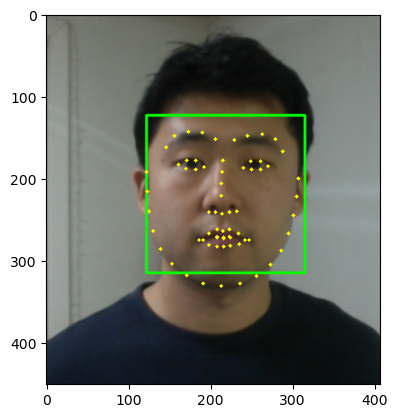

In [10]:
for landmark in list_landmarks:
    for point in landmark:
        cv.circle(face, point, 2, (0, 255, 255), -1)
        
face_rgb_landmark = cv.cvtColor(face, cv.COLOR_BGR2RGB)
plt.imshow(face_rgb_landmark)
plt.show()

고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해 주세요.

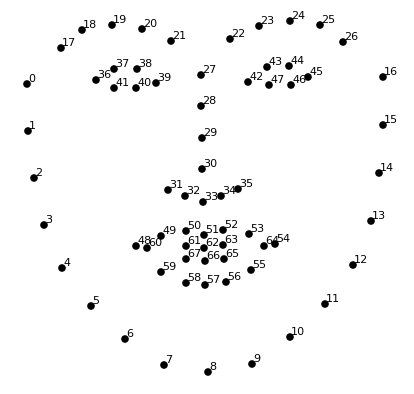

코 끝인 33 번보다 좋은 위치가 있을 거예요.

In [11]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks) :
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(213, 221)
(x,y) : (213,243)
(w,h) : (194,194)


In [12]:
sticker_path = my_image_path + '/cat-whiskers.png' # 스티커 이미지의 경로
img_sticker = cv.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(194, 194, 3)


In [26]:
#refine x and y
refine_x = x - w//2
refine_y = y - h//2
print(f'refine_y : {refine_y}, refine_x : {refine_x}')

refine_y : 146, refine_x : 116


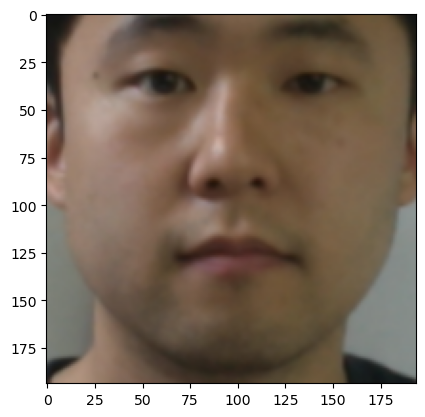

In [27]:
# 스티커가 적용될 범위
sticker_area = face_show_rgb[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]]
plt.imshow(sticker_area)
plt.show()

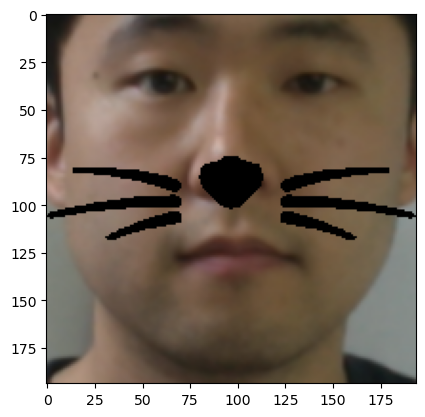

In [28]:
plt.imshow(np.where(img_sticker != 0, sticker_area,img_sticker).astype(np.uint8))
plt.show()

## Step 4. 스티커 적용하기

1. 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

2. 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다.</br> opencv 의 cv2.addWeighted() 를 참고하세요.

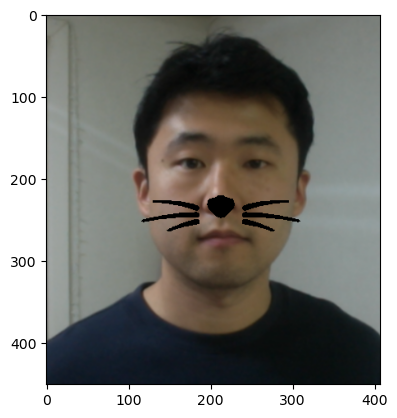

In [32]:
#고양이 붙히기
face_show_rgb[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]] = \
    np.where(img_sticker != 0, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(face_show_rgb)
plt.show()

In [33]:
img_path =  my_image_path +'/me2.png'
model_path ='/Users/seungyonglee/Desktop/Life3/aiffel/project/data/camera_sticker/model/shape_predictor_68_face_landmarks.dat'
sticker_path = my_image_path + '/cat-whiskers.png'

def draw_wiskers(img_path, model_path, sticker_path) :
    '''
    img_path : 이미지 경로
    model_path : 랜드마크 model 경로
    sticker_path : 스티커 이미지 경로
    '''

    #사진 준비
    face = cv.imread(img_path,-1).copy()

    #얼굴 검출 face detection using HOG(Histogram of Oriented Gradients)
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환
    face_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
    dlib_rects = detector_hog(face_rgb,2) #upsampling


    #draw rectangle
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv.rectangle(face, (l,t),(r,b),(0,255,0),2,lineType=cv.LINE_AA)

    face_show_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)

    #model to plot face landmark
    model_path = model_path
    landmark_predictor = dlib.shape_predictor(model_path)


    # find landmark points and plot them in image
    list_landmarks = []

    #find coordinate
    for dlib_rect in dlib_rects :
        points= landmark_predictor(face_rgb, dlib_rect)

        list_points = list(map(lambda p : (p.x,p.y), points.parts()))

        list_landmarks.append(list_points)


    #plotting
    for landmark in list_landmarks:
        for point in landmark:
            cv.circle(face, point, 2, (0, 255, 255), -1)
            

    face_rgb_landmark = cv.cvtColor(face, cv.COLOR_BGR2RGB)


    for dlib_rect, landmark in zip(dlib_rects, list_landmarks) :
        x = landmark[30][0]
        y = landmark[33][1]
        w = h = dlib_rect.width()
    
    
    #sticker image load
    _sticker_path = sticker_path # 스티커 이미지의 경로
    img_sticker = cv.imread(_sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
    img_sticker = cv.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))

    # 위치
    refine_x = x - w//2
    refine_y = y - h//2

    #스티커 적용하기

    face = cv.imread(img_path,-1).copy()
    face_final = cv.cvtColor(face, cv.COLOR_BGR2RGB)

    # 스티커가 적용될 범위
    sticker_area = face_final[refine_y : refine_y + img_sticker.shape[0], refine_x : refine_x + img_sticker.shape[1] ]
    
    face_final[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]] = \
        np.where(img_sticker != 0, sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(face_final)
    plt.show()


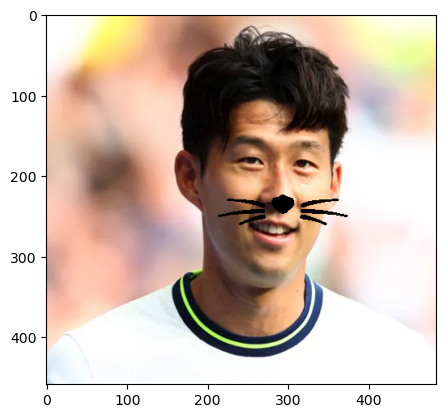

In [34]:
img_path =  my_image_path +'/son.png'
draw_wiskers(img_path, model_path, sticker_path)

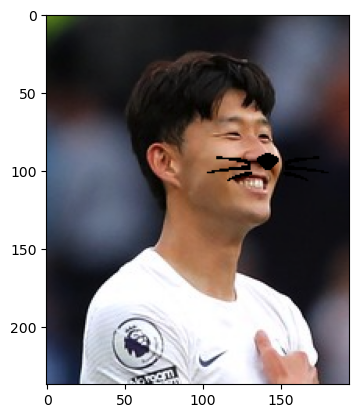

In [35]:
img_path =  my_image_path +'/son_side.png'
draw_wiskers(img_path, model_path, sticker_path)

## Step 5. 문제점 찾아보기

1. 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

2. 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

> 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

> 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

> 실행 속도가 중요할까요?

> 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

### 5.1. multiple people

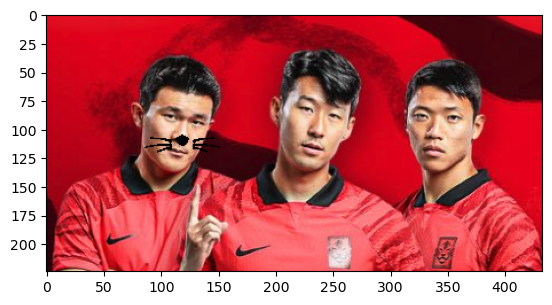

In [36]:
img_path =  my_image_path +'/team.png' # 여러명에 이미지가 들어갔을때는 적용이 불가? 
draw_wiskers(img_path, model_path, sticker_path)

여러명이 들어간 이미지에는 필터가 적용이 되지 않고 있네요...

필터가 적용이 되는 부분을 살펴보고 수정해볼 필요가 있을 것 같습니다. 

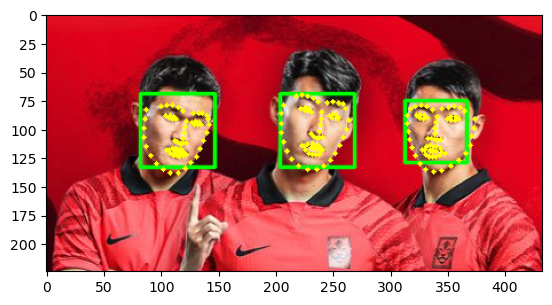

In [37]:
#사진 준비
face = cv.imread(img_path,-1).copy()

#얼굴 검출 face detection using HOG(Histogram of Oriented Gradients)
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환
face_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(face_rgb,2) #upsampling


#draw rectangle
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv.rectangle(face, (l,t),(r,b),(0,255,0),2,lineType=cv.LINE_AA)

face_show_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)

#model to plot face landmark
model_path = model_path
landmark_predictor = dlib.shape_predictor(model_path)


# find landmark points and plot them in image
list_landmarks = []

#find coordinate
for dlib_rect in dlib_rects :
    points= landmark_predictor(face_rgb, dlib_rect)

    list_points = list(map(lambda p : (p.x,p.y), points.parts()))

    list_landmarks.append(list_points)


#plotting
for landmark in list_landmarks:
    for point in landmark:
        cv.circle(face, point, 2, (0, 255, 255), -1)


face_rgb_landmark = cv.cvtColor(face, cv.COLOR_BGR2RGB)


plt.imshow(face_rgb_landmark)
plt.show()

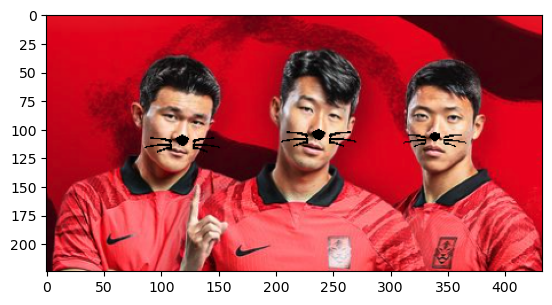

In [38]:
x =[]
y =[]
w =[]
h =[]
for dlib_rect, landmark in zip(dlib_rects, list_landmarks) :
    x.append(landmark[30][0])
    y.append(landmark[33][1])
    w.append(dlib_rect.width())
    h.append(dlib_rect.width())
    

#스티커 적용하기

face = cv.imread(img_path,-1).copy()
face_final = cv.cvtColor(face, cv.COLOR_BGR2RGB)

for i in range(len(x)):
    
    #sticker image load
    _sticker_path = sticker_path # 스티커 이미지의 경로
    img_sticker = cv.imread(_sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
    img_sticker = cv.resize(img_sticker, (w[i],h[i])) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))

    # 위치
    refine_x = x[i] - w[i]//2
    refine_y = y[i] - h[i]//2

    sticker_area = face_final[refine_y : refine_y + img_sticker.shape[0], refine_x : refine_x + img_sticker.shape[1] ]

    face_final[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]] = \
        np.where(img_sticker != 0, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(face_final)
plt.show()

해당코드를 수정했으니 함수에도 수정하겠습니다. 

In [39]:
def draw_wiskers(img_path, model_path, sticker_path) :
    '''
    img_path : 이미지 경로
    model_path : 랜드마크 model 경로
    sticker_path : 스티커 이미지 경로
    '''

    #사진 준비
    face = cv.imread(img_path,-1).copy()

    #얼굴 검출 face detection using HOG(Histogram of Oriented Gradients)
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환
    face_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
    dlib_rects = detector_hog(face_rgb,2) #upsampling


    #draw rectangle
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv.rectangle(face, (l,t),(r,b),(0,255,0),2,lineType=cv.LINE_AA)

    face_show_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)

    #model to plot face landmark
    model_path = model_path
    landmark_predictor = dlib.shape_predictor(model_path)


    # find landmark points and plot them in image
    list_landmarks = []

    #find coordinate
    for dlib_rect in dlib_rects :
        points= landmark_predictor(face_rgb, dlib_rect)

        list_points = list(map(lambda p : (p.x,p.y), points.parts()))

        list_landmarks.append(list_points)


    #plotting
    for landmark in list_landmarks:
        for point in landmark:
            cv.circle(face, point, 2, (0, 255, 255), -1)
            

    face_rgb_landmark = cv.cvtColor(face, cv.COLOR_BGR2RGB)


    x =[]
    y =[]
    w =[]
    h =[]
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks) :
        x.append(landmark[30][0])
        y.append(landmark[33][1])
        w.append(dlib_rect.width())
        h.append(dlib_rect.width())


    #스티커 적용하기

    face = cv.imread(img_path,-1).copy()
    face_final = cv.cvtColor(face, cv.COLOR_BGR2RGB)

    for i in range(len(x)):

        #sticker image load
        _sticker_path = sticker_path # 스티커 이미지의 경로
        img_sticker = cv.imread(_sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
        img_sticker = cv.resize(img_sticker, (w[i],h[i])) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))

        # 위치
        refine_x = x[i] - w[i]//2
        refine_y = y[i] - h[i]//2

        sticker_area = face_final[refine_y : refine_y + img_sticker.shape[0], refine_x : refine_x + img_sticker.shape[1] ]

        face_final[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]] = \
            np.where(img_sticker != 0, sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(face_final)
    plt.show()


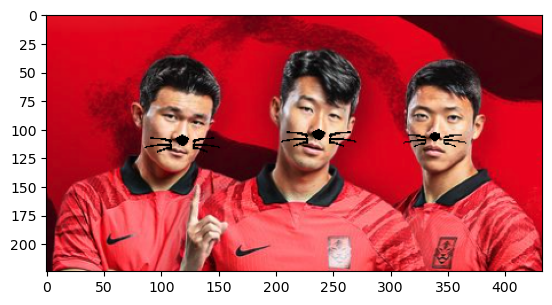

In [40]:
img_path =  my_image_path +'/team.png' #성공 
draw_wiskers(img_path, model_path, sticker_path)

아직 스티커가 완전하게 맞아 떨어지지는 않은것 같아요.

살짝 기울기도 넣어주면 좋을것 같네요.

### 5.2. add rotation

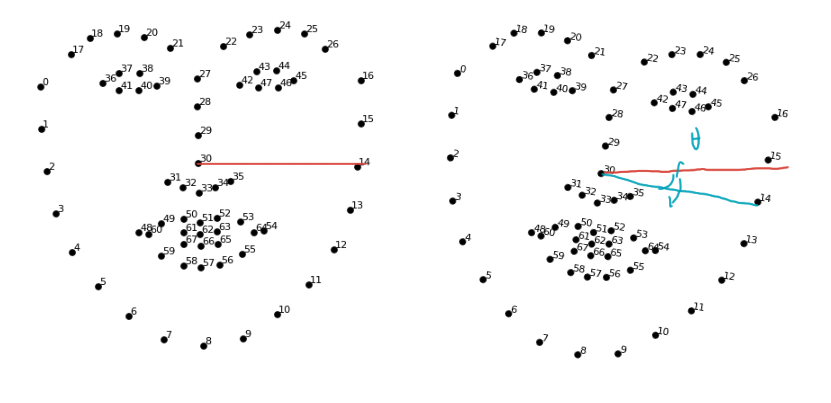

## How to Find Angle Between Two Lines?

$$ Tan\theta = \frac{m_1 - m_2}{1 + m_1 * m_2}$$

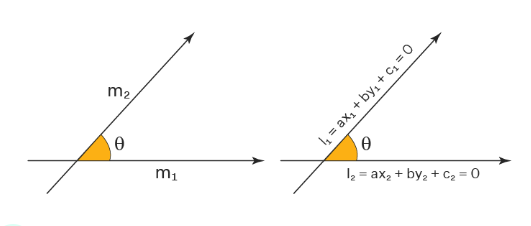

우선 얼굴이 얼마나 앞면에서 얼마나 기울어졌는지를 찾아봐야겠습니다.

위에 정방향일 경우에는 30 landmark point를 기준으로 잡았을 때, 14 landmark point와의 각도는 0도입니다.

14 landmark point가 움직임에 따라 정방향일 때 위치와의 변화된 각도를 구하면 기울기 각도가 나올 것 같습니다. 

식은 아래 링크에서 참고하였습니다.

https://www.cuemath.com/geometry/angle-between-two-lines/

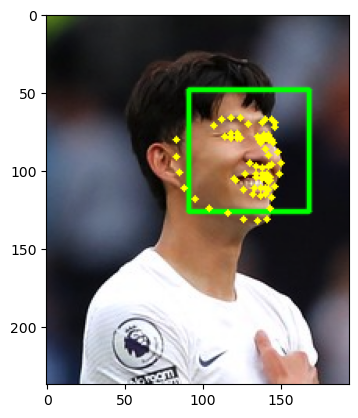

In [108]:
#사진 준비
# img_path =  my_image_path + '/son_rotation.png'
img_path =  my_image_path + '/son_side.png'
face = cv.imread(img_path,-1).copy()

#얼굴 검출 face detection using HOG(Histogram of Oriented Gradients)
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환
face_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
dlib_rects = detector_hog(face_rgb,2) #upsampling


#draw rectangle
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv.rectangle(face, (l,t),(r,b),(0,255,0),2,lineType=cv.LINE_AA)

face_show_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)

#model to plot face landmark
model_path = model_path
landmark_predictor = dlib.shape_predictor(model_path)


# find landmark points and plot them in image
list_landmarks = []

#find coordinate
for dlib_rect in dlib_rects :
    points= landmark_predictor(face_rgb, dlib_rect)

    list_points = list(map(lambda p : (p.x,p.y), points.parts()))

    list_landmarks.append(list_points)


#plotting
for landmark in list_landmarks:
    for point in landmark:
        cv.circle(face, point, 2, (0, 255, 255), -1)


face_rgb_landmark = cv.cvtColor(face, cv.COLOR_BGR2RGB)


plt.imshow(face_rgb_landmark)
plt.show()

In [111]:
center_coord = list_landmarks[0][41] # 기준점 
right_margin_coord = list_landmarks[0][41][0], dlib_rects[0].top() #기준점에서 right margin coordinate
ref_coord = list_landmarks[0][37] #14 landmark를 참조 점으로
print(center_coord)
print(right_margin_coord)
print(ref_coord)

(118, 79)
(118, 48)
(118, 76)


In [112]:
#위에 식을 이용해 각도 구하기

import math
m1 = (right_margin_coord[0] - center_coord[0])/(right_margin_coord[1] - center_coord[1]) # 첫번째 선 기울기
m2 = (ref_coord[0] - center_coord[0])/(ref_coord[1] - center_coord[1]) # 두번째 선 기울기
angle = math.atan((m1 - m2) / (1 + m1*m2)) * 100 # 각도 구하기
print(angle)

0.0


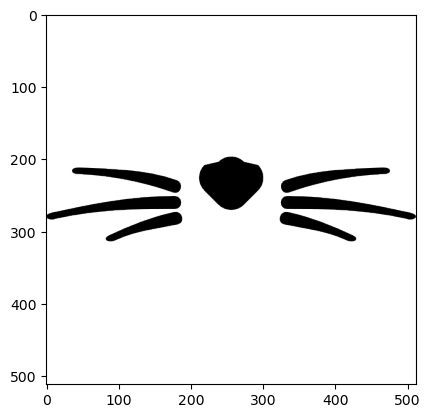

In [113]:
# rotate our image by 45 degrees around the center of the image
sticker_path = my_image_path + '/cat-whiskers.png'
image = cv.imread(sticker_path,-1)
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2) #중앙 찾기
M = cv.getRotationMatrix2D((cX, cY), -angle, 1.0) #중앙에서 rotation 각도
rotated = cv.warpAffine(image, M, (w, h)) #rotation 적용하기
plt.imshow(rotated)
plt.show()

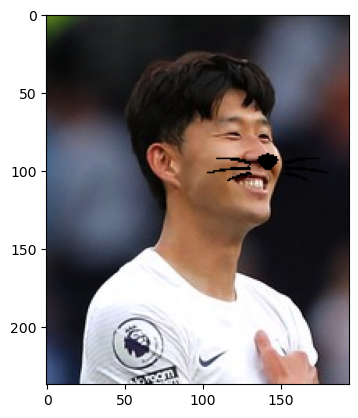

In [114]:
x =[]
y =[]
w =[]
h =[]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks) :
    x.append(landmark[30][0])
    y.append(landmark[33][1])
    w.append(dlib_rect.width())
    h.append(dlib_rect.width())


#스티커 적용하기

face = cv.imread(img_path,-1).copy()
face_final = cv.cvtColor(face, cv.COLOR_BGR2RGB)

for i in range(len(x)):

    #sticker image load
    img_sticker = cv.resize(rotated, (w[i],h[i])) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
    if img_sticker.shape[2] == 4 : #png 4개 채널을 3개 채널로 변환, 검정색 배경일 경우 흰색으로 변환
        img_sticker[:,:,0],img_sticker[:,:,1],img_sticker[:,:,2] = np.where(img_sticker[:,:,3] == 255,0,255),np.where(img_sticker[:,:,3] == 255,0,255),np.where(img_sticker[:,:,3] == 255,0,255)
        img_sticker = img_sticker[:,:,:3]
    # 위치
    refine_x = x[i] - w[i]//2
    refine_y = y[i] - h[i]//2

    sticker_area = face_final[refine_y : refine_y + img_sticker.shape[0], refine_x : refine_x + img_sticker.shape[1] ]

    face_final[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]] = \
        np.where(img_sticker != 0, sticker_area,img_sticker).astype(np.uint8)

plt.imshow(face_final)
plt.show()

아주 완벽하지는 않지만 적용이 되었습니다~!

## 2. 다른 스티커도 적용해보기

자 그럼 수염 스티커를 붙여보겠습니다~

In [149]:
import math

def draw_beard1(img_path, model_path, sticker_path, sticker_size=1) :
    '''
    img_path : 이미지 경로
    model_path : 랜드마크 model 경로
    sticker_path : 스티커 이미지 경로
    '''

    #사진 준비
    face = cv.imread(img_path,-1).copy()

    #얼굴 검출 face detection using HOG(Histogram of Oriented Gradients)
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 반환
    face_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)
    dlib_rects = detector_hog(face_rgb,2) #upsampling


    #draw rectangle
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv.rectangle(face, (l,t),(r,b),(0,255,0),2,lineType=cv.LINE_AA)

    face_show_rgb = cv.cvtColor(face, cv.COLOR_BGR2RGB)

    #model to plot face landmark
    model_path = model_path
    landmark_predictor = dlib.shape_predictor(model_path)


    # find landmark points and plot them in image
    list_landmarks = []

    #find coordinate
    for dlib_rect in dlib_rects :
        points= landmark_predictor(face_show_rgb, dlib_rect)

        list_points = list(map(lambda p : (p.x,p.y), points.parts()))

        list_landmarks.append(list_points)

    
    # position 리스트
    
    x =[]
    y =[]
    w =[]
    h =[]
    d =[]

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks) :
        x.append(landmark[30][0])
        y.append(landmark[33][1])
        w.append(dlib_rect.width())
        h.append(dlib_rect.width())
        
        #기울기 각도 구하기
        center_coord = landmark[41] # 기준점 
        right_margin_coord = landmark[41][0],dlib_rect.top() #기준점에서 right margin coordinate
        ref_coord = landmark[37] #14 landmark를 참조 점으로

        m1 = (right_margin_coord[0] - center_coord[0]) /(right_margin_coord[1] - center_coord[1])# 첫번째 선 기울기
        m2 = (ref_coord[0] - center_coord[0])/(ref_coord[1] - center_coord[1])  # 두번째 선 기울기
        d.append(math.atan((m1 - m2) / (1 + m1*m2)) * 100) # 각도 구하기

    #스티커 적용하기

    face = cv.imread(img_path,-1).copy()
    face_final = cv.cvtColor(face, cv.COLOR_BGR2RGB)

    for i in range(len(x)):
        #sticker image load
        img_sticker = cv.imread(sticker_path,-1)
        img_sticker = cv.resize(img_sticker, (int(w[i]*sticker_size),int(h[i]*sticker_size))) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
        
        
        # rotate our image by degrees around the center of the image
        (ht, wt) = img_sticker.shape[:2]
        (cX, cY) = (wt // 2, ht// 2) #중앙 찾기
        M = cv.getRotationMatrix2D((cX, cY), -d[i]*0.55, 1.0) #중앙에서 rotation 각도, smoothing을 위해 0.55 가중치 적용
        img_sticker = cv.warpAffine(img_sticker, M, (wt, ht)) #rotation 적용하기
        
        if img_sticker.shape[2] == 4 : #png 4개 채널을 3개 채널로 변환, 검정색 배경일 경우 흰색으로 변환
            img_sticker[:,:,0],img_sticker[:,:,1],img_sticker[:,:,2] = np.where(img_sticker[:,:,3] == 255,0,255),np.where(img_sticker[:,:,3] == 255,0,255),np.where(img_sticker[:,:,3] == 255,0,255)
            img_sticker = img_sticker[:,:,:3]
        
        # 이미지 crop 사이즈 설정을 위한 작업
        refine_x = x[i] - int(w[i] *sticker_size)//2
        refine_y = y[i] - int(h[i] *sticker_size)//2

        sticker_area = face_final[refine_y : refine_y + img_sticker.shape[0], refine_x : refine_x + img_sticker.shape[1] ]

        face_final[refine_y:refine_y+img_sticker.shape[0], refine_x:refine_x+img_sticker.shape[1]] = \
            np.where(img_sticker == 255, sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(face_final)
    plt.show()

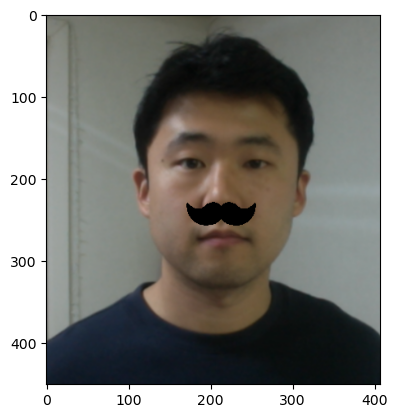

In [151]:
sticker_path = my_image_path + '/beard1.png'
img_path =  my_image_path +'/me2.png'
draw_beard1(img_path, model_path, sticker_path, sticker_size=0.5) #

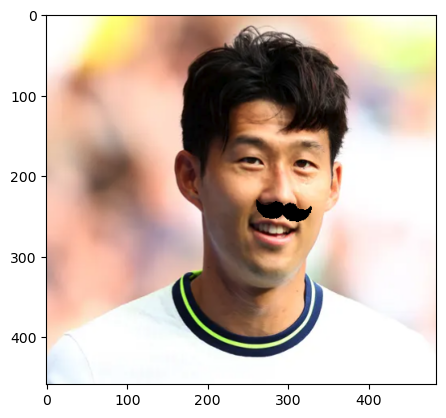

In [137]:
img_path =  my_image_path +'/son.png'
draw_beard1(img_path, model_path, sticker_path, sticker_size=0.5) #

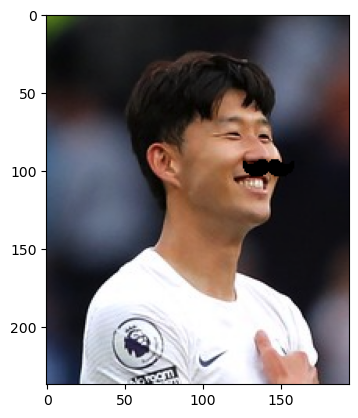

In [138]:
img_path =  my_image_path +'/son_side.png'
draw_beard1(img_path, model_path, sticker_path, sticker_size=0.5) #

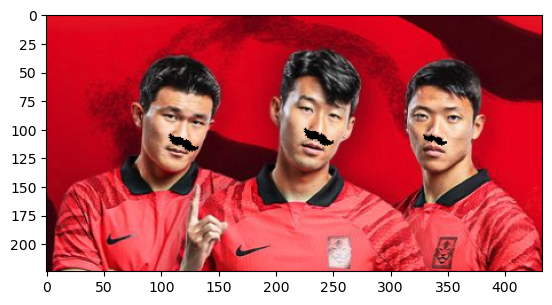

In [139]:
img_path =  my_image_path +'/team.png'
draw_beard1(img_path, model_path, sticker_path, sticker_size=0.5) #

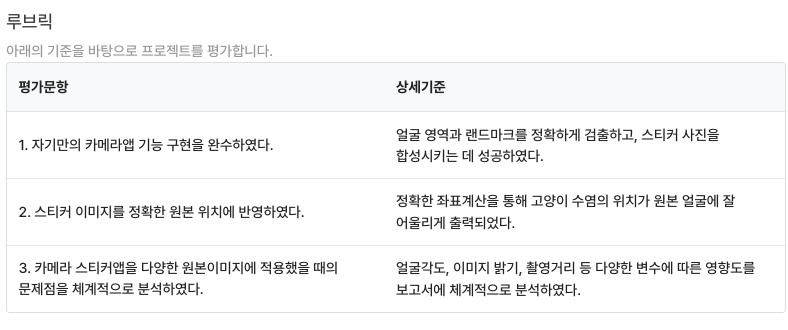